In [2]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

randomness = 42

In [4]:
# Läser in MNIST dataset.
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
X, y = mnist["data"], mnist["target"].astype(np.uint8)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [5]:
# Normaliserar
X = X / 255.0

In [6]:
# Delar upp i tränings- och testdel.
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=10000, random_state=randomness)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=randomness)
print('Träning: ', X_train.shape, '\nValidering:', X_val.shape,'\nTest: ', X_test.shape)

Träning:  (50000, 784) 
Validering: (10000, 784) 
Test:  (10000, 784)


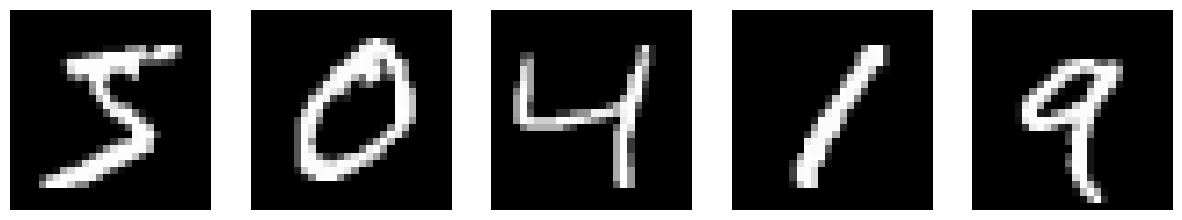

In [7]:
# Hur ser bilderna ut?
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28, 28)
    ax.imshow(some_digit_image, cmap="grey")
    ax.axis("off")

In [8]:
# Initierar klassificeringsmodeller.
param_grid = [
    {
        'model': [SGDClassifier(max_iter=1000, random_state=randomness)],
        'model__loss': ['log_loss', 'hinge'],
        'model__alpha': [0.0001, 0.001, 0.01],
    },
    {
        'model': [RandomForestClassifier(random_state=randomness, n_jobs=-1)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    },
    {
        'model': [ExtraTreesClassifier(random_state=randomness, n_jobs=-1)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    }
]


In [9]:
# Utvärderar med Randomized Search
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SGDClassifier())
])

randomized_search = RandomizedSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, random_state=randomness)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('model', SGDClassifier())]),
                   n_jobs=-1,
                   param_distributions=[{'model': [SGDClassifier(random_state=42)],
                                         'model__alpha': [0.0001, 0.001, 0.01],
                                         'model__loss': ['log_loss', 'hinge']},
                                        {'model': [RandomForestClassifier(n_jobs=-1,
                                                                          random_state=42)],
                                         'model__max_depth': [None, 10, 20],
                                         'model__n_estimators': [50, 100, 200]},
                                        {'model': [ExtraTreesClassifier(n_jobs=-1,
                                                                        random_state=42)],
                                         'model__max_depth': [None, 10, 20],
                                         'model__n_estimators': [50, 100,
                                                                 200]}],
                   random_state=42, scoring='accuracy')

In [10]:
best_model = randomized_search.best_estimator_

print(
    'Bästa modellen:', best_model,
    '\nBästa noggranhet på valideringsdatan', randomized_search.best_score_)

Bästa modellen: Pipeline(steps=[('scaler', StandardScaler()),
                ('model', ExtraTreesClassifier(n_jobs=-1, random_state=42))]) 
Bästa noggranhet på valideringsdatan 0.9675200435748875


In [11]:
# Initierar modeller med de bästa hypermaramterarna.
sgd = SGDClassifier(loss='log_loss', alpha=0.001, max_iter=1000, random_state=randomness)
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=randomness, n_jobs=-1)
extra_trees = ExtraTreesClassifier(n_estimators=100, max_depth=20, random_state=randomness, n_jobs=-1)

In [11]:
# Använder voting-klassificerare med återläggning.
voting_clf = VotingClassifier(
    estimators=[('sgd', sgd),
                ('rf', rand_forest),
                ('et', extra_trees)
    ],
    voting='hard'
)

In [12]:
# Tränar voting-klassificeraren.
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20, n_jobs=-1,
                                                     random_state=42)),
                             ('et',
                              ExtraTreesClassifier(max_depth=20, n_jobs=-1,
                                                   random_state=42))])

In [13]:
# Utvärderar på valideringsdelen
accuracy = voting_clf.score(X_val, y_val)
accuracy

0.9673

In [14]:
# Väljer voting-klassificeraren och tränar om den på hela träningsdelen.
voting_clf.fit(X_train_val, y_train_val)

VotingClassifier(estimators=[('sgd',
                              SGDClassifier(alpha=0.001, loss='log_loss',
                                            random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=20, n_jobs=-1,
                                                     random_state=42)),
                             ('et',
                              ExtraTreesClassifier(max_depth=20, n_jobs=-1,
                                                   random_state=42))])

Text(0.5, 1.0, 'Confusion matrix')

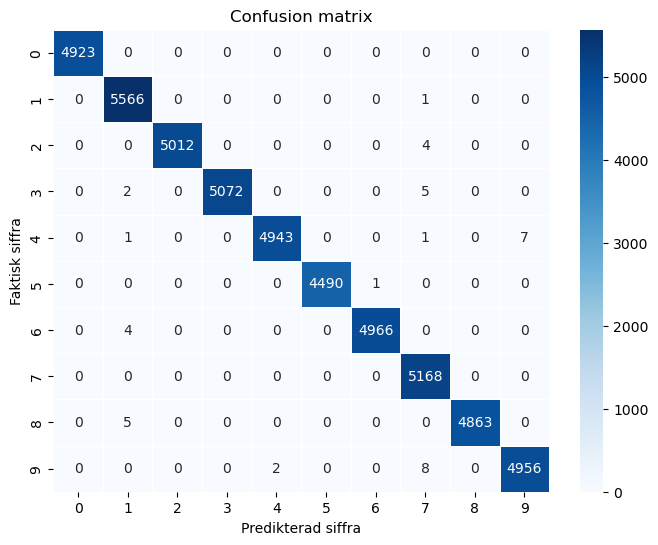

In [ ]:
# Confusion matrix
y_train_pred = voting_clf.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_train_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.xlabel('Predikterad siffra')
plt.ylabel('Faktisk siffra')
plt.title('Confusion matrix')

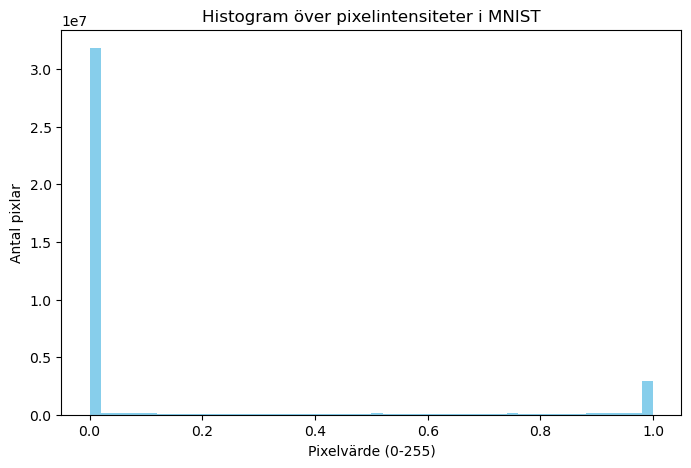

In [19]:
pixel_values = X_train.flatten()

plt.figure(figsize=(8, 5))
plt.hist(pixel_values, bins=50, color="skyblue")
plt.xlabel("Pixelvärde (0-255)")
plt.ylabel("Antal pixlar")
plt.title("Histogram över pixelintensiteter i MNIST")
plt.show()

In [16]:
# Testar på testdatan
y_pred = voting_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9649


In [17]:
# Sparar modellen
joblib.dump(voting_clf, "voting_model.pkl")

['voting_model.pkl']